_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment **failed the inspection, the target is `1`.**
- When the establishment **passed, the target is `0`.**

#### Run this cell to load the data:

In [15]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [16]:
import altair.vegalite.v2 as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import category_encoders as ce
from scipy.stats import randint
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

from eli5.xgboost import explain_weights_xgboost

# Better stack traces
import stackprinter

stackprinter.set_excepthook(style="lightbg")

In [17]:
train_url = (
    "https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5"
)
test_url = (
    "https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a"
)

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape == (17306, 17)

---------------

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

In [18]:
train.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,5.191600e+04,5.191100e+04,51890.000000,51718.000000,51718.000000,51916.000000
mean,1.330265e+06,1.549491e+06,60628.834669,41.879568,-87.676663,0.258610
std,6.202664e+05,9.018283e+05,22.736963,0.081126,0.059509,0.437875
min,4.425000e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000
25%,6.796205e+05,1.140745e+06,60614.000000,41.830296,-87.707857,0.000000
50%,1.424226e+06,1.958619e+06,60625.000000,41.890166,-87.666524,0.000000
75%,1.946952e+06,2.215507e+06,60643.000000,41.939167,-87.634461,1.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000


In [19]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
State,51906,1,IL,51906
Risk,51904,3,Risk 1 (High),37731
City,51863,39,CHICAGO,51659
Inspection Type,51915,51,Canvass,24170
Facility Type,51692,329,Restaurant,34264
Inspection Date,51916,2257,2017-03-23T00:00:00,50
Location,51718,13410,"{'longitude': '-87.91442843927047', 'latitude'...",741
Address,51916,13954,11601 W TOUHY AVE,741
AKA Name,51293,16350,SUBWAY,802
DBA Name,51916,17049,SUBWAY,654


In [20]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


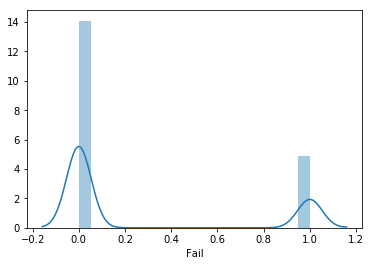

In [21]:
# Look at target variable distribution: check for class imbalance
sns.distplot(train['Fail']);

In [22]:
# Drop non-predictive and duplicative features, and engineer features
def wrangle(X):
    df = X.copy()
    encoder_ord = ce.OrdinalEncoder()

    # Encode Violations as a numeric feature
    df["Violation_Text_Length"] = df["Violations"].str.split(" ").str.len()

    # Drop
    df.drop(
        columns=["State", "Location", "Address", "AKA Name", "DBA Name", "Violations"],
        inplace=True,
    )

    # Convert: similar to Jake VDP's method
    df["Inspection Date"] = pd.to_datetime(
        df["Inspection Date"], infer_datetime_format=True
    ).values.astype(np.float)
    df["Inspection Date"] = (
        df["Inspection Date"] - df["Inspection Date"].min()
    ) / 365.0

    df[
        ["City", "Risk", "Inspection Type", "Facility Type"]
    ] = encoder_ord.fit_transform(
        df[["City", "Risk", "Inspection Type", "Facility Type"]]
    )

    return df

In [23]:
# Now wrangle train and test sets
# What happens to the train set must also happen to the test set
X_train = wrangle(train).drop(columns="Fail")
X_test = wrangle(test).drop(columns="Fail")
y_train = train["Fail"]
y_test = test["Fail"]

In [24]:
X_train.isna().sum()

Inspection ID               0
License #                   5
Facility Type               0
Risk                        0
City                        0
Zip                        26
Inspection Date             0
Inspection Type             0
Latitude                  198
Longitude                 198
Violation_Text_Length    9655
dtype: int64

In [25]:
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

In [26]:
wrangle(train).corr()['Fail'].sort_values(ascending=False)

Fail                     1.000000
Violation_Text_Length    0.544683
Inspection Type          0.084138
License #                0.043235
Risk                     0.019954
Longitude                0.015747
Zip                      0.014190
Inspection Date          0.013286
Facility Type            0.011775
Inspection ID            0.004624
City                    -0.010147
Latitude                -0.014143
Name: Fail, dtype: float64

**Above**, it is shown that `Violation_Text_Length` is the source of data leakage. In production usage the model would not have access to this data because it wouldn't have been "generated" by the inspector yet. This information is only available after the verdict of Pass or Fail has been given, so it must be dropped before the model is fit.

In [27]:
X_train.drop(columns="Violation_Text_Length", inplace=True)
X_test.drop(columns="Violation_Text_Length", inplace=True)

------------------

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._

In [28]:
# Decision trees aren't very sensitive to scaling, so its not performed here

# Hyperparamter optimization
param_distributions = {"n_estimators": randint(50, 300), "max_depth": randint(2, 5)}

search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter=5,
    scoring="roc_auc",
    n_jobs=-1,
    cv=3,
    verbose=3,
    return_train_score=True,
    random_state=42,
)

search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   13.6s remaining:   37.6s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   28.3s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   29.8s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E1EA62DFD0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E1EA628198>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=3)

In [29]:
best = search.best_estimator_
print("Best estimator ROC AUC score: ", search.best_score_)

Best estimator ROC AUC score:  0.7305793147459074


In [30]:
pd.Series(best.feature_importances_, X_train.columns).sort_values()

City               0.012537
Risk               0.022765
Facility Type      0.067634
Zip                0.069614
Inspection Date    0.096668
Inspection Type    0.096998
Longitude          0.136259
License #          0.137248
Latitude           0.141537
Inspection ID      0.218740
dtype: float32

In [31]:
y_pred_proba = best.predict_proba(X_test.values)[:, 1]
print("Test ROC AUC:", roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.6468852364799114


----------------

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

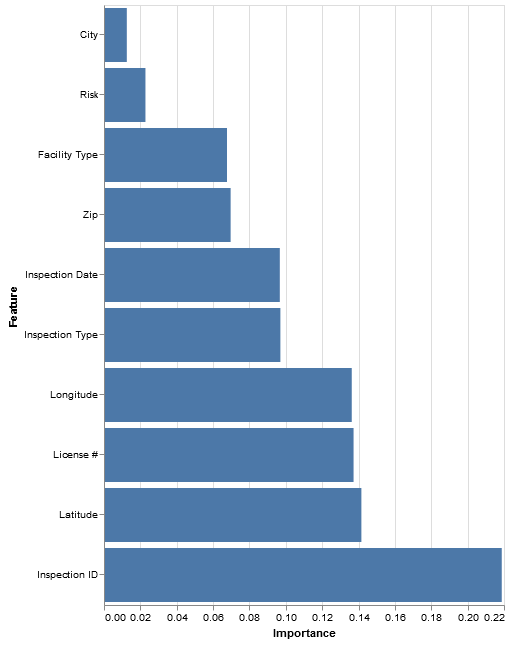

In [32]:
# Create DataFrame of features and importances
importances = pd.DataFrame(
    {"feature": X_train.columns.tolist(), "importance": best.feature_importances_}
)

# Create bar chart object
bars = (
    alt.Chart(importances)
    .mark_bar()
    .encode(
        alt.X("importance:Q", title="Importance"),
        alt.Y(
            "feature:N",
            title="Feature",
            sort=alt.EncodingSortField(field="importance", op="sum", order="ascending"),
        ),
    )
)

# Plot
bars.properties(height=600)

In [33]:
feature_names = X_test.columns.tolist()
explain_weights_xgboost(best, top=None, feature_names=feature_names)

Weight,Feature
0.4507,Inspection Type
0.0887,Inspection ID
0.0785,Zip
0.0697,Facility Type
0.0665,License #
0.0617,Latitude
0.0585,Inspection Date
0.0577,Longitude
0.0485,Risk
0.0196,City


-----------

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

**What does Gradient Descent seek to minimize?**

* Gradient Descent seeks to minimize the cost function. A cost function may also be referred to as a loss function, scoring function, or error function. An example of a cost function is the Sum of Squared Error. The Sum of Squared Error metric is especially useful when gradient descent is being applied to various forms of linear regression; univariate, bivariate, etc., as well as many other linear and polynomial functions.

**What is the "Learning Rate" and what is its function?**

* The learning rate is the coefficient (of the negative gradient) that scales the distance of the X-value for each iteration of Gradient Descent. The higher the learning rate is set the more likely it is that the Gradient Descent algorithm will overcorrect- jump "over" the minima- and not reach convergence. Finding an appropriate learning rate / "alpha" is one way to optimize the execution of Gradient Descent if necessary. When the alpha is set too low many iterations are necessary to reach the minimum, and if its too high it may never reach convergence or also take unnecessary extra iterations.